## Dental Enumeration and Diagnosis on Panoramic X-rays ##
### Download and process the Dentex training data ###

Full data set: https://zenodo.org/records/7812323/files/training_data.zip

Object detection data: https://dsets.s3.amazonaws.com/dentex/dentex-quadrant-enumeration.tar.gz

### DATA ###
 
The DENTEX dataset comprises panoramic dental X-rays obtained from three different institutions using standard clinical conditions but varying equipment and imaging protocols, resulting in diverse image quality reflecting heterogeneous clinical practice. The dataset includes X-rays from patients aged 12 and above, randomly selected from the hospital's database to ensure patient privacy and confidentiality.

To enable effective use of the FDI system, the dataset is hierarchically organized into three types of data;

(a) 693 X-rays labeled for quadrant detection and quadrant classes only,

(b) 634 X-rays labeled for tooth detection with quadrant and tooth enumeration classes,

(c) 1005 X-rays fully labeled for abnormal tooth detection with quadrant, tooth enumeration, and diagnosis classes.

The diagnosis class includes four specific categories: caries, deep caries, periapical lesions, and impacted teeth. An additional 1571 unlabeled X-rays are provided for pre-training.

In [1]:
import os
import sys
import glob
import logging
import json
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2
import computervision
from computervision.dentex import Dentex

# Print version info
print(f'Package version: {computervision.__version__}')
print(f'Python version:  {sys.version}')

Package version: v0.0.1
Python version:  3.12.3 (main, Jun 18 2025, 17:59:45) [GCC 13.3.0]


In [2]:
data_dir = os.path.join(os.environ.get('HOME'), 'data')
print(f'data_dir: {data_dir}')

# Directory to store the dentex data set
dataset_dir = os.path.join(data_dir, 'dentex')
Path(dataset_dir).mkdir(parents=True, exist_ok=True)

data_dir: /app/data


## Download the Dentex data set ##

In [3]:
url = 'https://dsets.s3.amazonaws.com/dentex/dentex-quadrant-enumeration.tar.gz'
# The Dentex class in src/computervision/dentex.py contains 
# short methods for working with the dentex data set
url = os.environ.get('DT_URL')
print(f'Location of the data set for manual download: \n {url}')
tar_file = Dentex().download(path=dataset_dir, url=url)

Location of the data set for manual download: 
 https://dsets.s3.amazonaws.com/dentex/dentex-quadrant-enumeration.tar.gz


dentex-quadrant-enumeration.tar.gz: 1.72GB [01:07, 25.3MB/s]                               


Extracting from .gz archive.


In [4]:
# After extraction from the .tar.gz archive, the images should be on the local fs
xrays_dir = os.path.join(dataset_dir, 'quadrant_enumeration/xrays')
# Let's make sure that we have the expected number of images available
expected_images = 634
file_list = glob.glob(os.path.join(xrays_dir, '*.png'))
print(f'Found {len(file_list)} images in {xrays_dir}.')
# We want to be sure that the number of images is correct before we continue
assert expected_images == len(file_list), \
    f'WARNING: expected images ({expected_images}) != images on file system ({len(file_list)})' 

Found 634 images in /app/data/dentex/quadrant_enumeration/xrays.


## Load annotations ##

In [5]:
# The annotations come in a json file
json_file = os.path.join(dataset_dir, 'quadrant_enumeration/train_quadrant_enumeration.json')
with open(json_file, 'r') as file:
    annotations = json.load(file)

# Convert every item into a data frame
annotations = {k: pd.DataFrame(v) for k, v in annotations.items()}
display(annotations.keys())
images = annotations.get('images').rename(columns={'id': 'image_id'})
df = annotations.get('annotations').merge(images, on='image_id', how='inner')
display(df.loc[df['file_name'].isnull()])

display(df.head(2))
print(f'Number of image files: {len(df['file_name'].unique())}')
print(f'Number of annotations: {df.shape[0]}')

dict_keys(['images', 'annotations', 'categories_1', 'categories_2'])

,iscrowd,image_id,bbox,segmentation,id,area,category_id_1,category_id_2,height,width,file_name


,iscrowd,image_id,bbox,segmentation,id,area,category_id_1,category_id_2,height,width,file_name
0,0,1,"[1283.3333333333333, 459.25925925925924, 100.0...","[[1366, 459, 1383, 662, 1380, 716, 1295, 721, ...",1,22904,0,0,1316,2710,train_283.png
1,0,1,"[1200.0, 460.18518518518516, 90.74074074074065...","[[1290, 463, 1290, 619, 1276, 719, 1224, 725, ...",2,18597,0,1,1316,2710,train_283.png


Number of image files: 634
Number of annotations: 18095


### Categories ###

In [6]:
display(annotations.keys())

# Quadrants
display(annotations.get('categories_1'))

# Tooth numbers
display(annotations.get('categories_2'))

dict_keys(['images', 'annotations', 'categories_1', 'categories_2'])

,id,name,supercategory
0,0,1,1
1,1,2,2
2,2,3,3
3,3,4,4


,id,name,supercategory
0,0,1,1
1,1,2,2
2,2,3,3
3,3,4,4
4,4,5,5
5,5,6,6
6,6,7,7
7,7,8,8


## FDI - ADA Position Mapping ##

The **FDI World Dental Federation notation system** (also called the **international dental numbering system**) is a widely used method for identifying teeth. It is especially common outside of North America (where the Universal Numbering System is more common).

Here’s how it works:

### 1. Quadrant-Based System

* The mouth is divided into **four quadrants**, each assigned a number:

  * **1**: Upper right (maxillary right)
  * **2**: Upper left (maxillary left)
  * **3**: Lower left (mandibular left)
  * **4**: Lower right (mandibular right)

For **primary (deciduous) teeth**, quadrants are numbered **5–8** instead of 1–4.

### 2. Tooth Number Within the Quadrant

* Each tooth within a quadrant is given a **second digit** (1–8 for permanent teeth, 1–5 for primary teeth).
* Counting always starts from the midline (central incisor) and moves backward:

  * **1** = Central incisor
  * **2** = Lateral incisor
  * **3** = Canine
  * **4** = First premolar (or first primary molar in deciduous set)
  * **5** = Second premolar (or second primary molar)
  * **6** = First molar
  * **7** = Second molar
  * **8** = Third molar (wisdom tooth)

### 3. Two-Digit Number for Each Tooth

* The **first digit** = quadrant
* The **second digit** = position of the tooth in that quadrant

For example:

* **11** = Upper right central incisor
* **24** = Upper left first premolar
* **36** = Lower left first molar
* **48** = Lower right third molar (wisdom tooth)

For primary teeth:

* **51** = Upper right primary central incisor
* **75** = Lower left primary second molar

---

✅ **Advantages of the FDI system:**

* Simple two-digit code
* Logical quadrant + position structure
* Internationally recognized (endorsed by the WHO and FDI)

The **Universal Numbering System** is the most common dental notation system used in the **United States and Canada**. It is different from the FDI system and uses a **continuous numbering from 1 to 32** for permanent teeth (and letters A–T for primary teeth).

---

### 🔹 Permanent Teeth (1–32)

* Numbering starts from the **upper right third molar** (maxillary right wisdom tooth) as **#1**.
* Continues along the upper arch (right to left) until the **upper left third molar (#16)**.
* Then moves down to the **lower left third molar (#17)** and continues along the lower arch (left to right), ending with the **lower right third molar (#32)**.

So the sequence is:
➡️ Upper right → across the maxilla → upper left → down to lower left → across the mandible → lower right.

Examples:

* **#8** = Maxillary right central incisor
* **#14** = Maxillary left first molar
* **#25** = Mandibular right central incisor
* **#32** = Mandibular right third molar

---

### 🔹 Primary Teeth (A–T)

* Instead of numbers, primary teeth are labeled **A through T**.
* The pattern is similar:

  * **A** = Upper right second primary molar
  * Continues across to **J** = Upper left second primary molar
  * Then drops down to **K** = Lower left second primary molar
  * Continues across to **T** = Lower right second primary molar

---

✅ **Advantages:**

* Very simple (each tooth has a unique number or letter).
* Extremely common in North America, so widely recognized in dental records.

⚠️ **Limitations:**

* Not as internationally accepted as the FDI system.
* Does not indicate quadrant or tooth type as clearly.

---

Would you like me to **make a visual chart of the Universal Numbering System** (like the one I made for FDI) so you can compare them side by side?


In [9]:
# Create position number mapping
def fdi_ada_mapping():
    fdi, ada = [], []
    for q in range(1, 5):
        for p in range(1, 9):
            fdi.append(int(str(q) + str(p)))
        if q in [1, 3]:
            for a in range(8*q, 8*(q-1), -1):
                ada.append(a)
        else:
            for a in range(8*(q-1), 8*q, 1):
                ada.append(a + 1)
    return fdi, ada

# FDI2ADA mapping
fdi, ada = fdi_ada_mapping()
fdi2ada = dict(zip(fdi, ada))

# Create the FDI positions from the category data
category_1 = dict(zip(annotations.get('categories_1')['id'].tolist(), 
                      annotations.get('categories_1')['name'].tolist()))

category_2 = dict(zip(annotations.get('categories_2')['id'].tolist(),
                      annotations.get('categories_2')['name'].tolist()))

# Map the category IDs to the category names (quadrants and positions)
df_pos = df.assign(quadrant=df['category_id_1'].apply(lambda id: category_1.get(id)),
                   pos=df['category_id_2'].apply(lambda id: category_2.get(id)))

# Create the FDI positions
df_pos = df_pos.assign(fdi=df_pos['quadrant'].astype(str) + df_pos['pos'].astype(str))
df_pos = df_pos.astype({'fdi': int})

# Map FDI to ADA
df_pos = df_pos.assign(ada=df_pos['fdi'].\
    apply(lambda fdi: fdi2ada.get(fdi))).\
    reset_index(drop=True)

# Make sure that all positions were mapped
assert df_pos.loc[df_pos['ada'].isnull()].shape[0] == 0

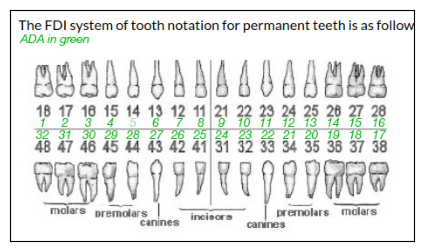

In [10]:
toothposition_image_name = 'toothpositions.jpg'
# This image is in the project repository
toothposition_image_dir = os.path.join(os.environ.get('HOME'), 'images')
toothpositon_image_file = os.path.join(toothposition_image_dir, toothposition_image_name)
fig, ax = plt.subplots(figsize=(6, 3))
img = plt.imread(toothpositon_image_file)
ax.imshow(img)
ax.set(xticks=[], yticks=[])
plt.show()

In [11]:
# Final data frame with ADA positions
display(df_pos.sample(2))
print(df_pos.shape)

,iscrowd,image_id,bbox,segmentation,id,area,category_id_1,category_id_2,height,width,file_name,quadrant,pos,fdi,ada
2617,0,91,"[1377.5, 457.5, 138.75, 172.5]","[[1400, 560, 1383, 531, 1377, 505, 1393, 485, ...",2618,13910,2,7,976,1976,train_393.png,3,8,38,17
11778,0,411,"[609.3846153846154, 505.0769230769231, 151.923...","[[647, 693, 672, 682, 703, 645, 740, 599, 761,...",11779,15125,3,4,976,1976,train_381.png,4,5,45,29


(18095, 15)


In [12]:
# Save the data frame
print(json_file)
parquet_file_name = f'{os.path.splitext(os.path.basename(json_file))[0]}.parquet'
parquet_file = os.path.join(data_dir, parquet_file_name)
df_pos.to_parquet(parquet_file)
print(f'Parquet file with annotations saved to: {parquet_file}')

/app/data/dentex/quadrant_enumeration/train_quadrant_enumeration.json
Parquet file with annotations saved to: /app/data/train_quadrant_enumeration.parquet
